#**Step 1: Install All the Required Packages**

In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.8 MB/s eta 0:00:00


#**Step 2: Import All the Required Libraries**

In [2]:
# Import the 'os' library for interacting with the operating system (e.g., file paths, environment variables)
import os

# Import PyTorch, a popular machine learning framework, used for building and training models
import torch

# Import the 'load_dataset' function to load and work with datasets for machine learning tasks
from datasets import load_dataset

# Import various utilities from Hugging Face's Transformers library
from transformers import (
    AutoModelForCausalLM,    # Automatically loads a pre-trained causal language model (e.g., for text generation)
    AutoTokenizer,           # Automatically loads the tokenizer associated with the chosen model (for preparing text inputs)
    BitsAndBytesConfig,      # Used for configuring model's memory optimization (related to how models store numbers)
    HfArgumentParser,        # Helps with parsing arguments (e.g., from command line or configuration files)
    TrainingArguments,       # Defines settings for training models (e.g., learning rate, batch size, output directory)
    pipeline,                # A simple API for running various NLP tasks like text generation, translation, etc.
    logging,                 # Handles logging (outputting information such as warnings or progress) for models and processes
)

# Import specific utilities from the 'peft' library (used for model adaptation and optimization)
from peft import LoraConfig, PeftModel
# LoraConfig: Configuration for LoRA (Low-Rank Adaptation), a method to reduce model size
# PeftModel: A specialized model that uses parameter-efficient fine-tuning (PEFT), enabling lighter training

# Import the 'SFTTrainer' from the 'trl' (Transfer Learning for Text) library, used for training transformer models
from trl import SFTTrainer


#**In case of Llama 2, the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

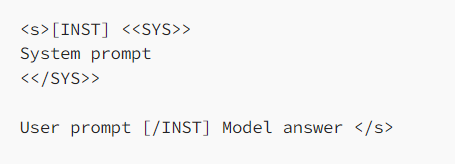

#We will reformat our instruction dataset to follow Llama 2 template.

- Orignal Dataset: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

- Reformat Dataset following the Llama 2 template with 1k sample: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k

- Complete Reformat Dataset following the Llama 2 template: https://huggingface.co/datasets/mlabonne/guanaco-llama2

To know how this dataset was created, you can check this notebook.  

https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing

### Note: You don’t need to follow a specific prompt template if you’re using the base Llama 2 model instead of the chat version.

#**How to fine tune Llama 2**

- Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)

- We also need to consider the overhead due to optimizer states, gradients, and forward activations

- Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.

- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

#**Step 3**

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [3]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"
# This is the name of the pre-trained model you are going to fine-tune, which is available on Hugging Face.

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"
# This specifies the dataset you will use for training. It's an instruction-tuning dataset hosted on Hugging Face.

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"
# This will be the name you give to the model after it's been fine-tuned.

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 16
# Defines the low-rank adaptation (LoRA) rank. It adjusts the capacity of the adapter layers.

# Alpha parameter for LoRA scaling
lora_alpha = 16
# This scales the LoRA updates, controlling the amount of LoRA's contribution to model training.

# Dropout probability for LoRA layers
lora_dropout = 0.1
# The dropout rate applied to LoRA layers to prevent overfitting.

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True
# This enables loading the base model in 4-bit precision to reduce memory consumption.

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"
# Sets the datatype used for calculations when the model is loaded in 4-bit precision. "float16" uses half precision.

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"
# This sets the type of quantization. "nf4" is a specific type of quantization that works well for 4-bit models.

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False
# This determines whether or not to use double quantization, a more aggressive memory reduction technique.

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"
# This sets the folder where the fine-tuned model and other outputs will be saved.

# Number of training epochs
num_train_epochs = 1
# Number of times the model will go over the entire dataset during training.

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False
# These flags enable training in half precision (float16) or bf16 precision, reducing memory usage and increasing speed on suitable hardware.

# Batch size per GPU for training
per_device_train_batch_size = 2
# The number of samples to process per training step on each GPU.

# Batch size per GPU for evaluation
per_device_eval_batch_size = 2
# The number of samples to process per evaluation step on each GPU.

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1
# This allows accumulation of gradients over several batches before updating the model, which effectively increases the batch size.

# Enable gradient checkpointing
gradient_checkpointing = True
# Reduces memory usage by only storing gradients for certain layers during backpropagation. It trades memory for a bit of extra computation time.

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3
# Caps the gradients to a maximum value during training, preventing them from becoming too large (which could destabilize the training process).

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-2
# The starting learning rate for the AdamW optimizer, which controls how much to adjust model weights during training.

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001
# Adds a small penalty to the model weights to prevent overfitting by discouraging overly large weights.

# Optimizer to use
optim = "paged_adamw_32bit"
# Specifies the optimizer algorithm used for training. AdamW is a version of Adam with weight decay; "paged_adamw_32bit" uses a memory-efficient variant.

# Learning rate schedule
lr_scheduler_type = "cosine"
# The learning rate decreases following a cosine function during training, starting high and tapering off smoothly.

# Number of training steps (overrides num_train_epochs)
max_steps = -1
# The maximum number of training steps. If set to -1, it is determined by `num_train_epochs`.

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03
# The fraction of training steps during which the learning rate will linearly increase from 0 to the set `learning_rate`.

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True
# Groups together input sequences of the same length into batches. This reduces wasted computation and improves training efficiency.

# Save checkpoint every X updates steps
save_steps = 0
# This defines how often (in number of steps) to save a checkpoint. If 0, no checkpoints will be saved during training.

# Log every X updates steps
logging_steps = 25
# Defines how often (in number of steps) to log information during training (like loss or accuracy).

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None
# Limits the length of input sequences during training. If set to `None`, it uses the maximum length allowed by the model.

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False
# If set to `True`, it combines multiple shorter sequences into a single input batch, saving memory and speeding up training.

# Load the entire model on the GPU 0
device_map = {"": 0}
# Specifies which device (GPU) to load the model on. Here, the model is loaded on GPU 0.


#**Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [4]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")
# Load the dataset for training. The 'split' argument specifies that we're loading the 'train' portion of the dataset.

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)
# Get the compute data type based on the `bnb_4bit_compute_dtype` string. This configures how the model processes data in 4-bit mode (e.g., using float16).

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)
# This configuration loads the model with 4-bit precision and applies nested quantization if enabled. It reduces memory use and optimizes computation.

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)
# This checks if the GPU can handle bfloat16 (a more efficient data format for training large models). If it does, it suggests enabling bf16 for faster training.

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1
# Load the pre-trained language model (Llama-2 in this case) with 4-bit quantization settings and map the model to a specific device (e.g., GPU).
# `use_cache` is set to False to save memory during fine-tuning. `pretraining_tp` refers to the number of tensor parallelism groups to use (set to 1 here).

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training
# Load the tokenizer associated with the model. The tokenizer processes input text into tokens the model understands.
# Set the padding token to the same as the end-of-sequence token (EOS) and ensure padding is applied to the right to avoid training issues.

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)
# Set up the LoRA (Low-Rank Adaptation) configuration, which reduces the number of trainable parameters to make fine-tuning more memory-efficient.
# `lora_alpha` scales the LoRA updates, `lora_dropout` prevents overfitting, and `r` sets the adaptation rank.
# The `task_type` is set to `CAUSAL_LM`, indicating this is a language modeling task (text generation).

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)
# These arguments configure the training process:
# - `output_dir`: Directory to save model checkpoints.
# - `num_train_epochs`: Number of times the model will see the entire dataset.
# - `per_device_train_batch_size`: Batch size per GPU.
# - `gradient_accumulation_steps`: How many steps to accumulate gradients before updating the model (increases effective batch size).
# - `optim`: Optimizer type (AdamW in a memory-efficient form).
# - `save_steps` and `logging_steps`: Control how often checkpoints are saved and how often logging occurs.
# - `learning_rate`: The speed at which the model's parameters are updated.
# - `weight_decay`: Regularization term to avoid overfitting.
# - `fp16` and `bf16`: Enable mixed-precision training (saves memory, speeds up training).
# - `max_grad_norm`: Clipping to avoid exploding gradients.
# - `lr_scheduler_type`: Type of learning rate schedule.
# - `warmup_ratio`: Percentage of steps where the learning rate increases linearly.
# - `group_by_length`: Group sequences by length to improve training efficiency.
# - `report_to="tensorboard"`: Logs data to TensorBoard for monitoring.

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)
# Initializes the supervised fine-tuning trainer (`SFTTrainer`) for fine-tuning the model using the dataset.
# - `model`: The model to train.
# - `train_dataset`: The training dataset loaded earlier.
# - `peft_config`: The LoRA configuration to use for efficient fine-tuning.
# - `dataset_text_field`: Specifies which field in the dataset contains the text data.
# - `max_seq_length`: Maximum length of the input sequences.
# - `tokenizer`: The tokenizer for preparing inputs.
# - `args`: Training arguments set earlier.
# - `packing`: If set to `True`, combines shorter examples to increase training efficiency.

# Train model
trainer.train()
# This kicks off the fine-tuning process using the model, dataset, and configurations you have set up.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

(…)-00000-of-00001-9ad84bb9cf65a42f.parquet:   0%|          | 0.00/967k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type:

Step,Training Loss
25,1.407400
50,1.669400
75,1.218800
100,1.446500
125,1.175200
150,1.365600
175,1.172200
200,1.468600
225,1.156800
250,1.541700


TrainOutput(global_step=250, training_loss=1.3622349395751954, metrics={'train_runtime': 1548.6154, 'train_samples_per_second': 0.646, 'train_steps_per_second': 0.161, 'total_flos': 8690465746747392.0, 'train_loss': 1.3622349395751954, 'epoch': 1.0})

In [ ]:
# Save trained model
trainer.model.save_pretrained(new_model)


##**Step 5: Check the plots on tensorboard, as follows**

In [6]:
%load_ext tensorboard
%tensorboard --logdir results/runs

<IPython.core.display.Javascript object>

###**Step 6:Use the text generation pipeline to ask questions like “What is a large language model?” Note that I’m formatting the input to match Llama 2 prompt template.**

In [7]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)
# This sets the logging level to only show critical issues, ignoring warnings or info logs.
# Helps reduce clutter in the output, showing only the most important messages.

# Run text generation pipeline with our next model
prompt = "What is a large language model?"
# The input prompt to generate text. Here, it asks the model about large language models.

pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
# Initializes a text-generation pipeline using Hugging Face's `pipeline` method.
# - `task="text-generation"`: Specifies that the pipeline will perform text generation.
# - `model=model`: The fine-tuned model (loaded earlier) is passed to the pipeline for generating text.
# - `tokenizer=tokenizer`: The tokenizer for processing the input text into tokens the model can work with.
# - `max_length=200`: Limits the maximum length of the generated text to 200 tokens.

result = pipe(f"<s>[INST] {prompt} [/INST]")
# Runs the pipeline with the input prompt.
# The prompt is wrapped with special tokens (`<s>[INST]` and `[/INST]`) that are used by the model to understand it's handling an instruction.
# The result is a list containing the generated text.

print(result[0]['generated_text'])
# Prints the generated text from the first item in the result list.
# `result[0]` gets the first (and usually only) generated output, and `['generated_text']` extracts the actual text content.


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=Tr

<s>[INST] What is a large language model? [/INST] A large language model is a type of artificial intelligence (AI) model that is trained on a large dataset of text to generate human-like language outputs. It is designed to be able to understand and generate text in a way that is similar to human language, and can be used for a variety of applications such as chatbots, language translation, and text summarization.

Large language models are typically trained using deep learning techniques, such as recurrent neural networks (RNNs) or transformer models, and are often based on pre-trained models such as BERT or RoBERTa. These models are trained on large datasets of text, such as books, articles, or websites, and are designed to learn the patterns and structures of language.

Some examples of large language models include:

* BERT (Bidirectional Encoder Representations from Transformers):


In [ ]:
# Empty VRAM
del model
del pipe
del trainer
# Deletes the model, pipeline, and trainer objects from memory.
# This helps free up GPU memory (VRAM) and system memory (RAM) when these objects are no longer needed.

import gc
# Imports Python's garbage collection module, which manages memory.
# This is used to clean up and free memory that may still be occupied after the deletion of objects.

gc.collect()
gc.collect()
# Explicitly runs the garbage collector twice to free up unused memory.
# This ensures that any remaining references to the deleted objects are removed and memory is reclaimed.


20933

You can train a Llama 2 model on the entire dataset using [mlabonne/guanaco-llama2](https://huggingface.co/datasets/mlabonne/guanaco-llama2)

#**Step 7: Store New Llama2 Model (Llama-2-7b-chat-finetune)**

How can we store our new Llama-2-7b-chat-finetune model now? We need to merge the weights from LoRA with the base model. Unfortunately, as far as I know, there is no straightforward way to do it: we need to reload the base model in FP16 precision and use the peft library to merge everything.

In [ ]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,  # Load the model in FP16 to reduce memory usage and improve performance.
    device_map=device_map,      # Specifies which devices (e.g., GPU) to load the model onto.
)
# This loads the base model (without LoRA weights) in FP16 precision.
# `low_cpu_mem_usage=True` ensures that less CPU memory is used during the loading process.
# `return_dict=True` returns model outputs as a dictionary (which is the default format for Hugging Face models).

model = PeftModel.from_pretrained(base_model, new_model)
# Load the LoRA fine-tuned model on top of the base model using `PeftModel`.
# `from_pretrained` combines the base model with the LoRA weights saved in `new_model` directory.

model = model.merge_and_unload()
# This method merges the LoRA layers into the base model's weights and then removes the LoRA-specific layers.
# This reduces the model back to its original form but retains the fine-tuned knowledge.
# After this, the model is "merged," meaning it's a standalone model with all the learned parameters.

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# Reloads the tokenizer from the base model (Llama-2 in this case) so it matches the structure of the original model.
# This is necessary when saving the tokenizer later for inference use or sharing.

tokenizer.pad_token = tokenizer.eos_token
# Set the padding token to the same value as the EOS (end-of-sequence) token. This is common practice in causal language models.
# This ensures proper tokenization when generating text with padding.

tokenizer.padding_side = "right"
# Specifies that padding should be applied on the right side of the input sequence (common for text-generation tasks).
# Ensures the model processes padded inputs correctly.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:556: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapters_weights = torch.load(


#**Step 8: Push Model to Hugging Face Hub**

Our weights are merged and we reloaded the tokenizer. We can now push everything to the Hugging Face Hub to save our model.

In [ ]:
import locale
# The `locale` module is imported, which deals with internationalization settings, including character encoding.

locale.getpreferredencoding = lambda: "UTF-8"
# This overrides the default behavior of `locale.getpreferredencoding()` to always return "UTF-8".
# Normally, `locale.getpreferredencoding()` returns the system's preferred encoding (which can vary across environments).
# By setting it to always return "UTF-8", it ensures that the encoding used is UTF-8, regardless of the system settings.


In [ ]:
!huggingface-cli login
model.push_to_hub("SURESHBEEKHANI/Llama-2-7b-chat-finetune", check_pr=True)
tokenizer.push_to_hub("SURESHBEEKHANI/Llama-2-7b-chat-finetune", check_pr=True)




    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 

You can now use this model for inference by loading it like any other Llama 2 model from the Hub.